In [1]:
# enable CUDA https://medium.com/@leennewlife/how-to-setup-pytorch-with-cuda-in-windows-11-635dfa56724b
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
import torch
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.2.1+cu121
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Tue_Feb_27_16:28:36_Pacific_Standard_Time_2024
Cuda compilation tools, release 12.4, V12.4.99
Build cuda_12.4.r12.4/compiler.33961263_0
**********
CUDNN version: 8801
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
# Imagenes
import PIL
from PIL import Image


# GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Dataset and Dataloader

Dataset

In [5]:
class Car_Dataset(Dataset):
    def __init__(self, data_paths_dict, masks_paths_dict=None, img_transforms=None, mask_transforms=None):
        '''
        data_paths_dict - train data paths
        masks_paths_dict - train masks paths
        '''
        self.train_data = data_paths_dict # X
        self.train_masks = masks_paths_dict # y

        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        # Lista de tuplas  (clase, filename)
        # ordenada para que esten en el mismo orden que las mascaras
        self.images = []
        self.images = [(key, file) for key, dir in self.train_data.items() for file in sorted(os.listdir(dir))]
        self.masks =  [(key, file) for key, dir in self.train_masks.items() for file in sorted(os.listdir(dir))]

    def __len__(self):
        # Asegurarnos que sea el mismo numero de imagenes que de mascaras, habiendo mascaras
        if self.train_masks is not None:
            assert len(self.images) == len(self.masks), f'El numero de imagenes en {self.train_masks} y {self.train_data} no coincide'
        return len(self.images)


    def __getitem__(self, idx):
        '''
        Regresa un elemento del dataset en la posición de index
        Con iter se pueden iterar todos los elementos del dataset

        '''
        key, name = self.images[idx]
        image_name = os.path.join(self.train_data[key],name)
        img = Image.open(image_name).convert('RGB') # .convert('RGB') RGB

        # Aplicar transformaciones 
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img = T.ToTensor()(img) # Default trasnformation
        
        # Si no existen máscaras, retorna solamente img (Validación)
        if self.train_masks is None:
            return img
        else:
            key, name = self.images[idx]
            mask_name = os.path.join(self.train_masks[key], name)
            mask = Image.open(mask_name).convert('L') # .convert('L') grayscale
            # Aplicar transformaciones 
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = T.ToTensor()(mask)
            # Normalizamos la mascara para que sean zeros y unos
            mask_max = mask.max().item()
            mask /= mask_max
            
        # La mascara si existe
        return img, mask

# Transformaciones

In [9]:
transform_data = T.Compose([
    T.Resize([224,224]),
    T.ToTensor()
])

# Dataloaders

In [10]:
TRAIN_PATH = {
        "COVID-19": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\COVID-19\images",
        "Non-COVID": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\Non-COVID\images",
        "Normal": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\Normal\images"
}
TRAIN_MASKS_PATH = {
        "COVID-19": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\COVID-19\lung masks",
        "Non-COVID": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\Non-COVID\lung masks",
        "Normal": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\Normal\lung masks"
}
TEST_PATH = {
        "COVID-19": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Test\COVID-19\lung masks",
        "Non-COVID": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Test\Non-COVID\lung masks",
        "Normal": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Test\Normal\lung masks"
}

In [11]:
full_dataset = Car_Dataset(TRAIN_PATH, TRAIN_MASKS_PATH,
                           img_transforms=transform_data,
                           mask_transforms=transform_data)

In [12]:
len(full_dataset)

21715

In [13]:
BATCH_SIZE = 32
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE
print(TRAIN_SIZE, VAL_SIZE)

17372 4343


In [14]:
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])
print(len(train_dataset), len(val_dataset))

17372 4343


In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
imgs, masks_paths_dict = next(iter(train_loader))
print(imgs.shape, masks_paths_dict.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])


# Lets see the data

In [19]:
for i, (x,y) in enumerate(train_loader):
    print(i, x.shape, y.shape)
    if i==10: break

0 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
1 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
2 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
3 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
4 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
5 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
6 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
7 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
8 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
9 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])
10 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])


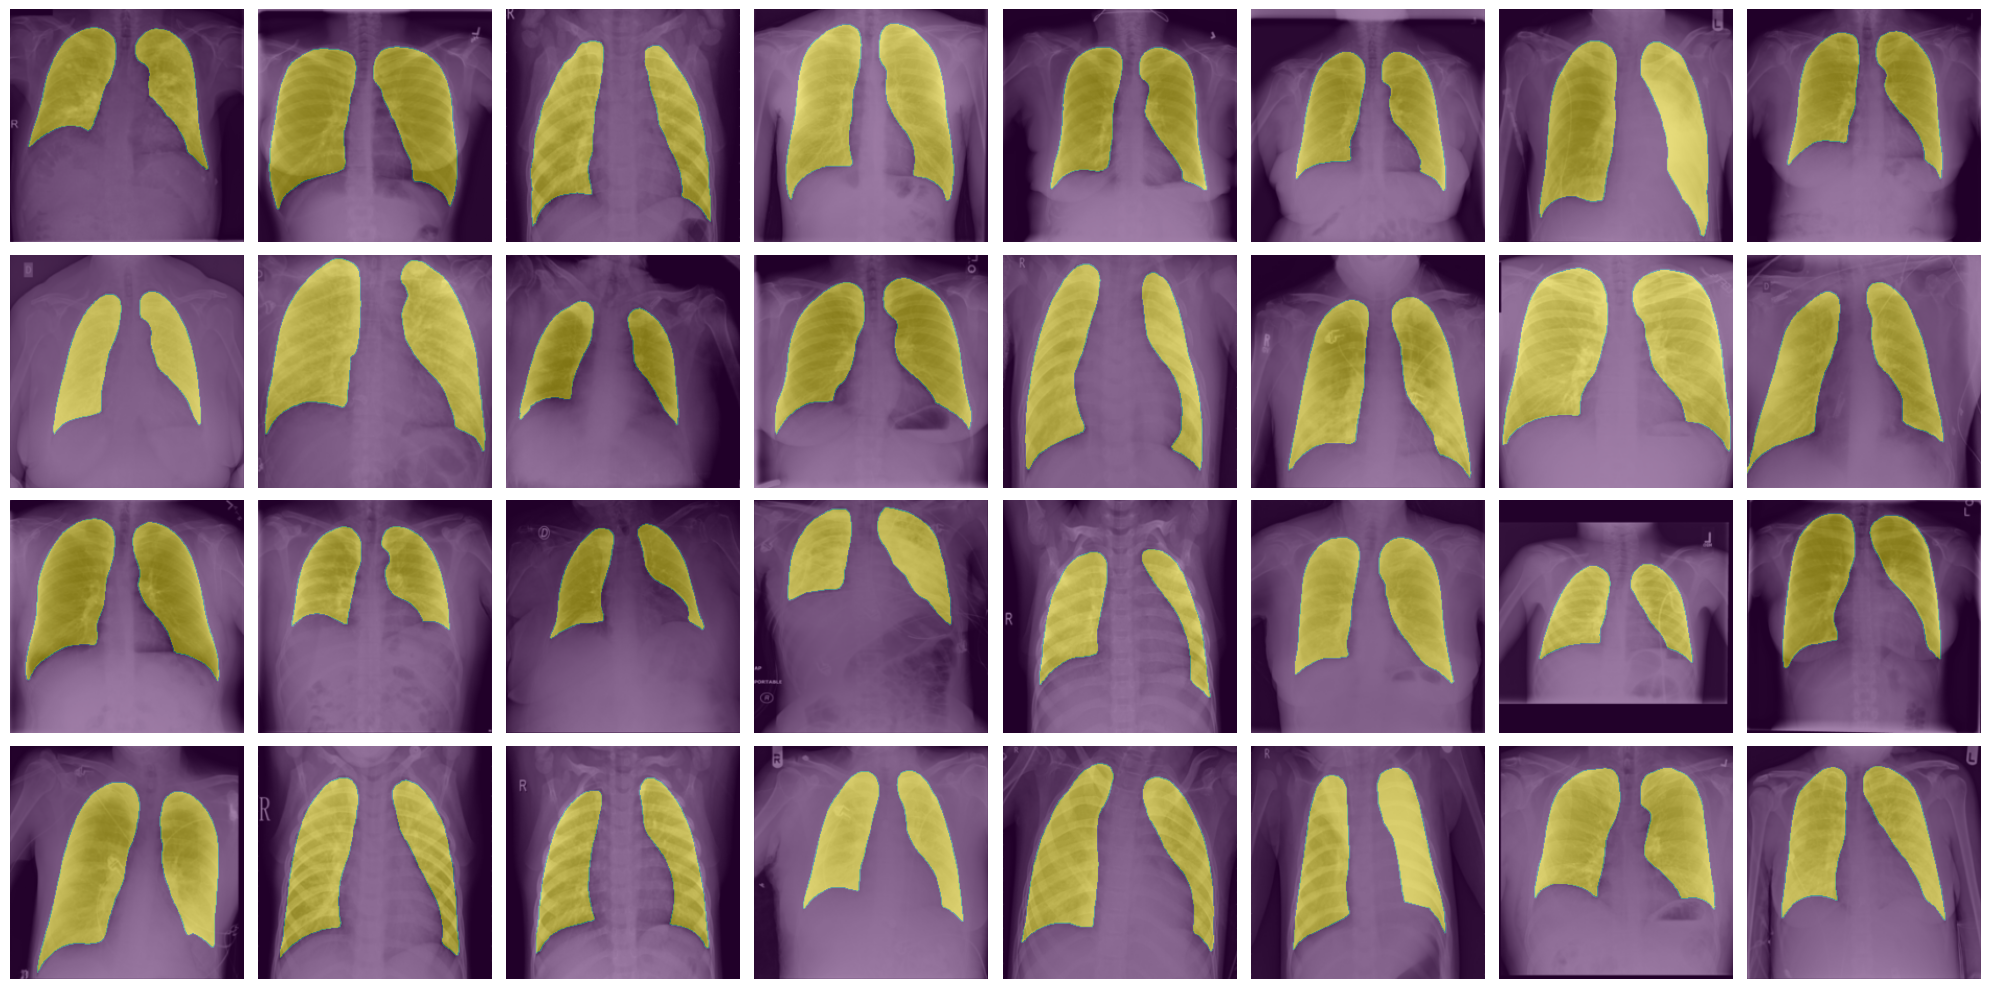

In [22]:
imgs, masks_paths_dict = next(iter(train_loader))
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        # Filas, columnas y posición
        plt.subplot(4, 8, i+1)
        # De la posición i, pasa todos los canales
        # tensor = imgs[i,...]
        # Canales en la ultima posición (alto, ancho, canal)
        img=imgs[i,...].permute(1,2,0).numpy() 
        mask = masks[i,...].permute(1,2,0).numpy()
        # Muestra la imagen utilizando matplotlib.
        plt.imshow(img)
        # Muestra la máscara encima de la imagen con transparencia (alpha=0.5),
        # permitiendo visualizar tanto la imagen como la máscara simultáneamente.
        plt.imshow(mask, alpha=0.5)
        # Desactiva los ejes para una visualización más limpia.
        plt.axis('Off')
    # Ajusta el layout de la figura para evitar solapamientos entre las subfiguras.
    plt.tight_layout()
    plt.show()

plot_mini_batch(imgs, masks_paths_dict)